In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 07:50:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   33C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
#     # Create the base model from the pre-trained model
#   base_model_2 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')
#   base_model_2.trainable = False  

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)


  x2 = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

  x1 = tf.keras.applications.densenet.preprocess_input(x)
  print("Using preprocessing")

  x1 = base_model_1(x1)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_1(x2) 
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  concatted = tf.keras.layers.Concatenate()([x1, x2])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 72s 136ms/step - loss: 0.5820 - accuracy: 0.7545 - val_loss: 0.4033 - val_accuracy: 0.8367
Epoch 2/100
360/360 [==============================] - 38s 106ms/step - loss: 0.4558 - accuracy: 0.8104 - val_loss: 0.3879 - val_accuracy: 0.8510
Epoch 3/100
360/360 [==============================] - 37s 104ms/step - loss: 0.4312 - accuracy: 0.8237 - val_loss: 0.3878 - val_accuracy: 0.8362
Epoch 4/100
360/360 [==============================] - 38s 105ms/step - loss: 0.4127 - accuracy: 0.8301 - val_loss: 0.3729 - val_accuracy: 0.8555
Epoch 5/100
360/360 [==============================] - 37s 104ms/step - loss: 0.4009 - accuracy: 0.8370 - val_loss: 0.3393 - val_accuracy: 0.8744
Epoch 6/100
360/360 [==============================] - 38s 105ms/step - lo

360/360 [==============================] - 38s 105ms/step - loss: 0.2836 - accuracy: 0.8875 - val_loss: 0.2764 - val_accuracy: 0.8996
Epoch 56/100
360/360 [==============================] - 37s 102ms/step - loss: 0.2766 - accuracy: 0.8917 - val_loss: 0.2557 - val_accuracy: 0.9073
Epoch 57/100
360/360 [==============================] - 38s 105ms/step - loss: 0.2785 - accuracy: 0.8879 - val_loss: 0.2644 - val_accuracy: 0.9036
Epoch 58/100
360/360 [==============================] - 37s 103ms/step - loss: 0.2742 - accuracy: 0.8921 - val_loss: 0.2728 - val_accuracy: 0.9015
Epoch 59/100
360/360 [==============================] - 37s 103ms/step - loss: 0.2756 - accuracy: 0.8898 - val_loss: 0.2629 - val_accuracy: 0.9024
Epoch 60/100
360/360 [==============================] - 38s 104ms/step - loss: 0.2755 - accuracy: 0.8922 - val_loss: 0.2591 - val_accuracy: 0.9010
Epoch 61/100
360/360 [==============================] - 37s 102ms/step - loss: 0.2733 - accuracy: 0.8933 - val_loss: 0.2952 - val_a

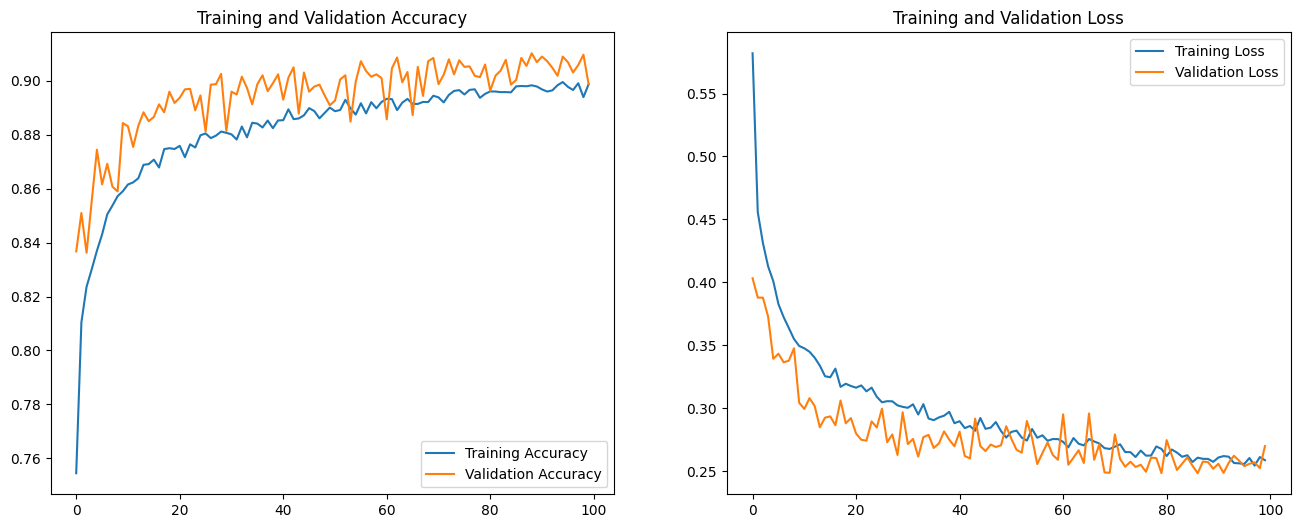

In [6]:
# DenseNet169 XYZ* + DenseNet201 XYZ*
conf1 = train_model()

In [7]:
np.max(conf1['val_acc'])

0.9102118611335754